## XGBoost for Stock Price Forecasting

In [1]:
!pip install --no-cache-dir xgboost pandas_datareader yfinance -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
# Ensure yfinance overrides
yf.pdr_override()

# Get the stock quote
df = pdr.get_data_yahoo('AMD', start='2022-04-01', end=datetime.now())

# Create a new dataframe with only the 'Close' column
data = df.filter(['Close']).values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and validation sets
training_data_len = int(len(scaled_data) * 0.95)
train_data = scaled_data[:training_data_len]
valid_data = scaled_data[training_data_len:]

# Function to create dataset for XGBoost
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step and create datasets
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_valid, y_valid = create_dataset(valid_data, time_step)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed


### Training the XGBoost Model and making forecast

In [4]:
# Initialize and train the XGBoost model
xgb_model = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
xgb_model.fit(X_train, y_train)

# Predict future prices
future_prices = []

# Get the last 60 days of data
last_60_days = scaled_data[-time_step:].reshape(1, -1)

for i in range(10):
    pred_price = xgb_model.predict(last_60_days)
    future_prices.append(pred_price[0])
    last_60_days = np.append(last_60_days, pred_price.reshape(1, -1), axis=1)[:, 1:]

# Inverse transform the predicted prices
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

print("Future Prices")
print(future_prices)

Future Prices
[[151.93184]
 [151.93184]
 [151.93184]
 [151.93184]
 [151.93184]
 [151.93184]
 [151.93184]
 [151.93184]
 [151.93184]
 [151.93184]]


In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


### Visualizing the Predictions

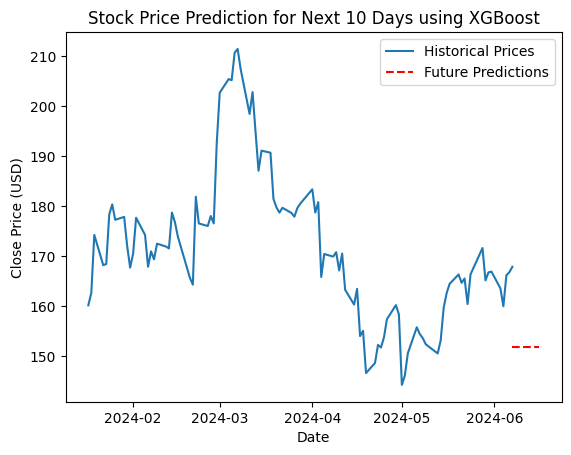

In [6]:
plt.plot(df.index[-100:], df['Close'].tail(100), label='Historical Prices')
plt.plot(pd.date_range(df.index[-1], periods=10), future_prices, linestyle='dashed', color='red', label='Future Predictions')
plt.title('Stock Price Prediction for Next 10 Days using XGBoost')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()